<a href="https://colab.research.google.com/github/noahrychener/Data-analysis-NMR-kinetics/blob/main/2024_01_13_function_fitting_with_sd_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Text DataFrame 0 Header:
['time', '[1+1]', '[2+1]', '[2+2]', 'NDI-cage', 'TMB']
         time     [1+1]     [2+1]     [2+2]  NDI-cage        TMB
0    0.000000  0.021721  0.007759  0.009094  0.010628  2018516.8
1    1.313611  0.052647  0.009613  0.011023  0.012848  2018516.8
2    2.314722  0.075689  0.011037  0.014859  0.016350  1930755.2
3    3.326944  0.096704  0.012037  0.013561  0.019117  2018516.8
4    4.313889  0.112927  0.014124  0.020445  0.021824  2007546.6
5    5.314167  0.122553  0.015493  0.024182  0.030412  2073367.8
6    6.313889  0.127413  0.021586  0.030403  0.035661  2040457.2
7    7.313611  0.130900  0.022668  0.038618  0.039693  2018516.8
8    8.313889  0.128315  0.026030  0.040113  0.049872  2084338.0
9    9.313611  0.122309  0.030013  0.046477  0.053027  2106278.4
10  10.311667  0.110643  0.035165  0.056338  0.060465  2084338.0
11  11.3144

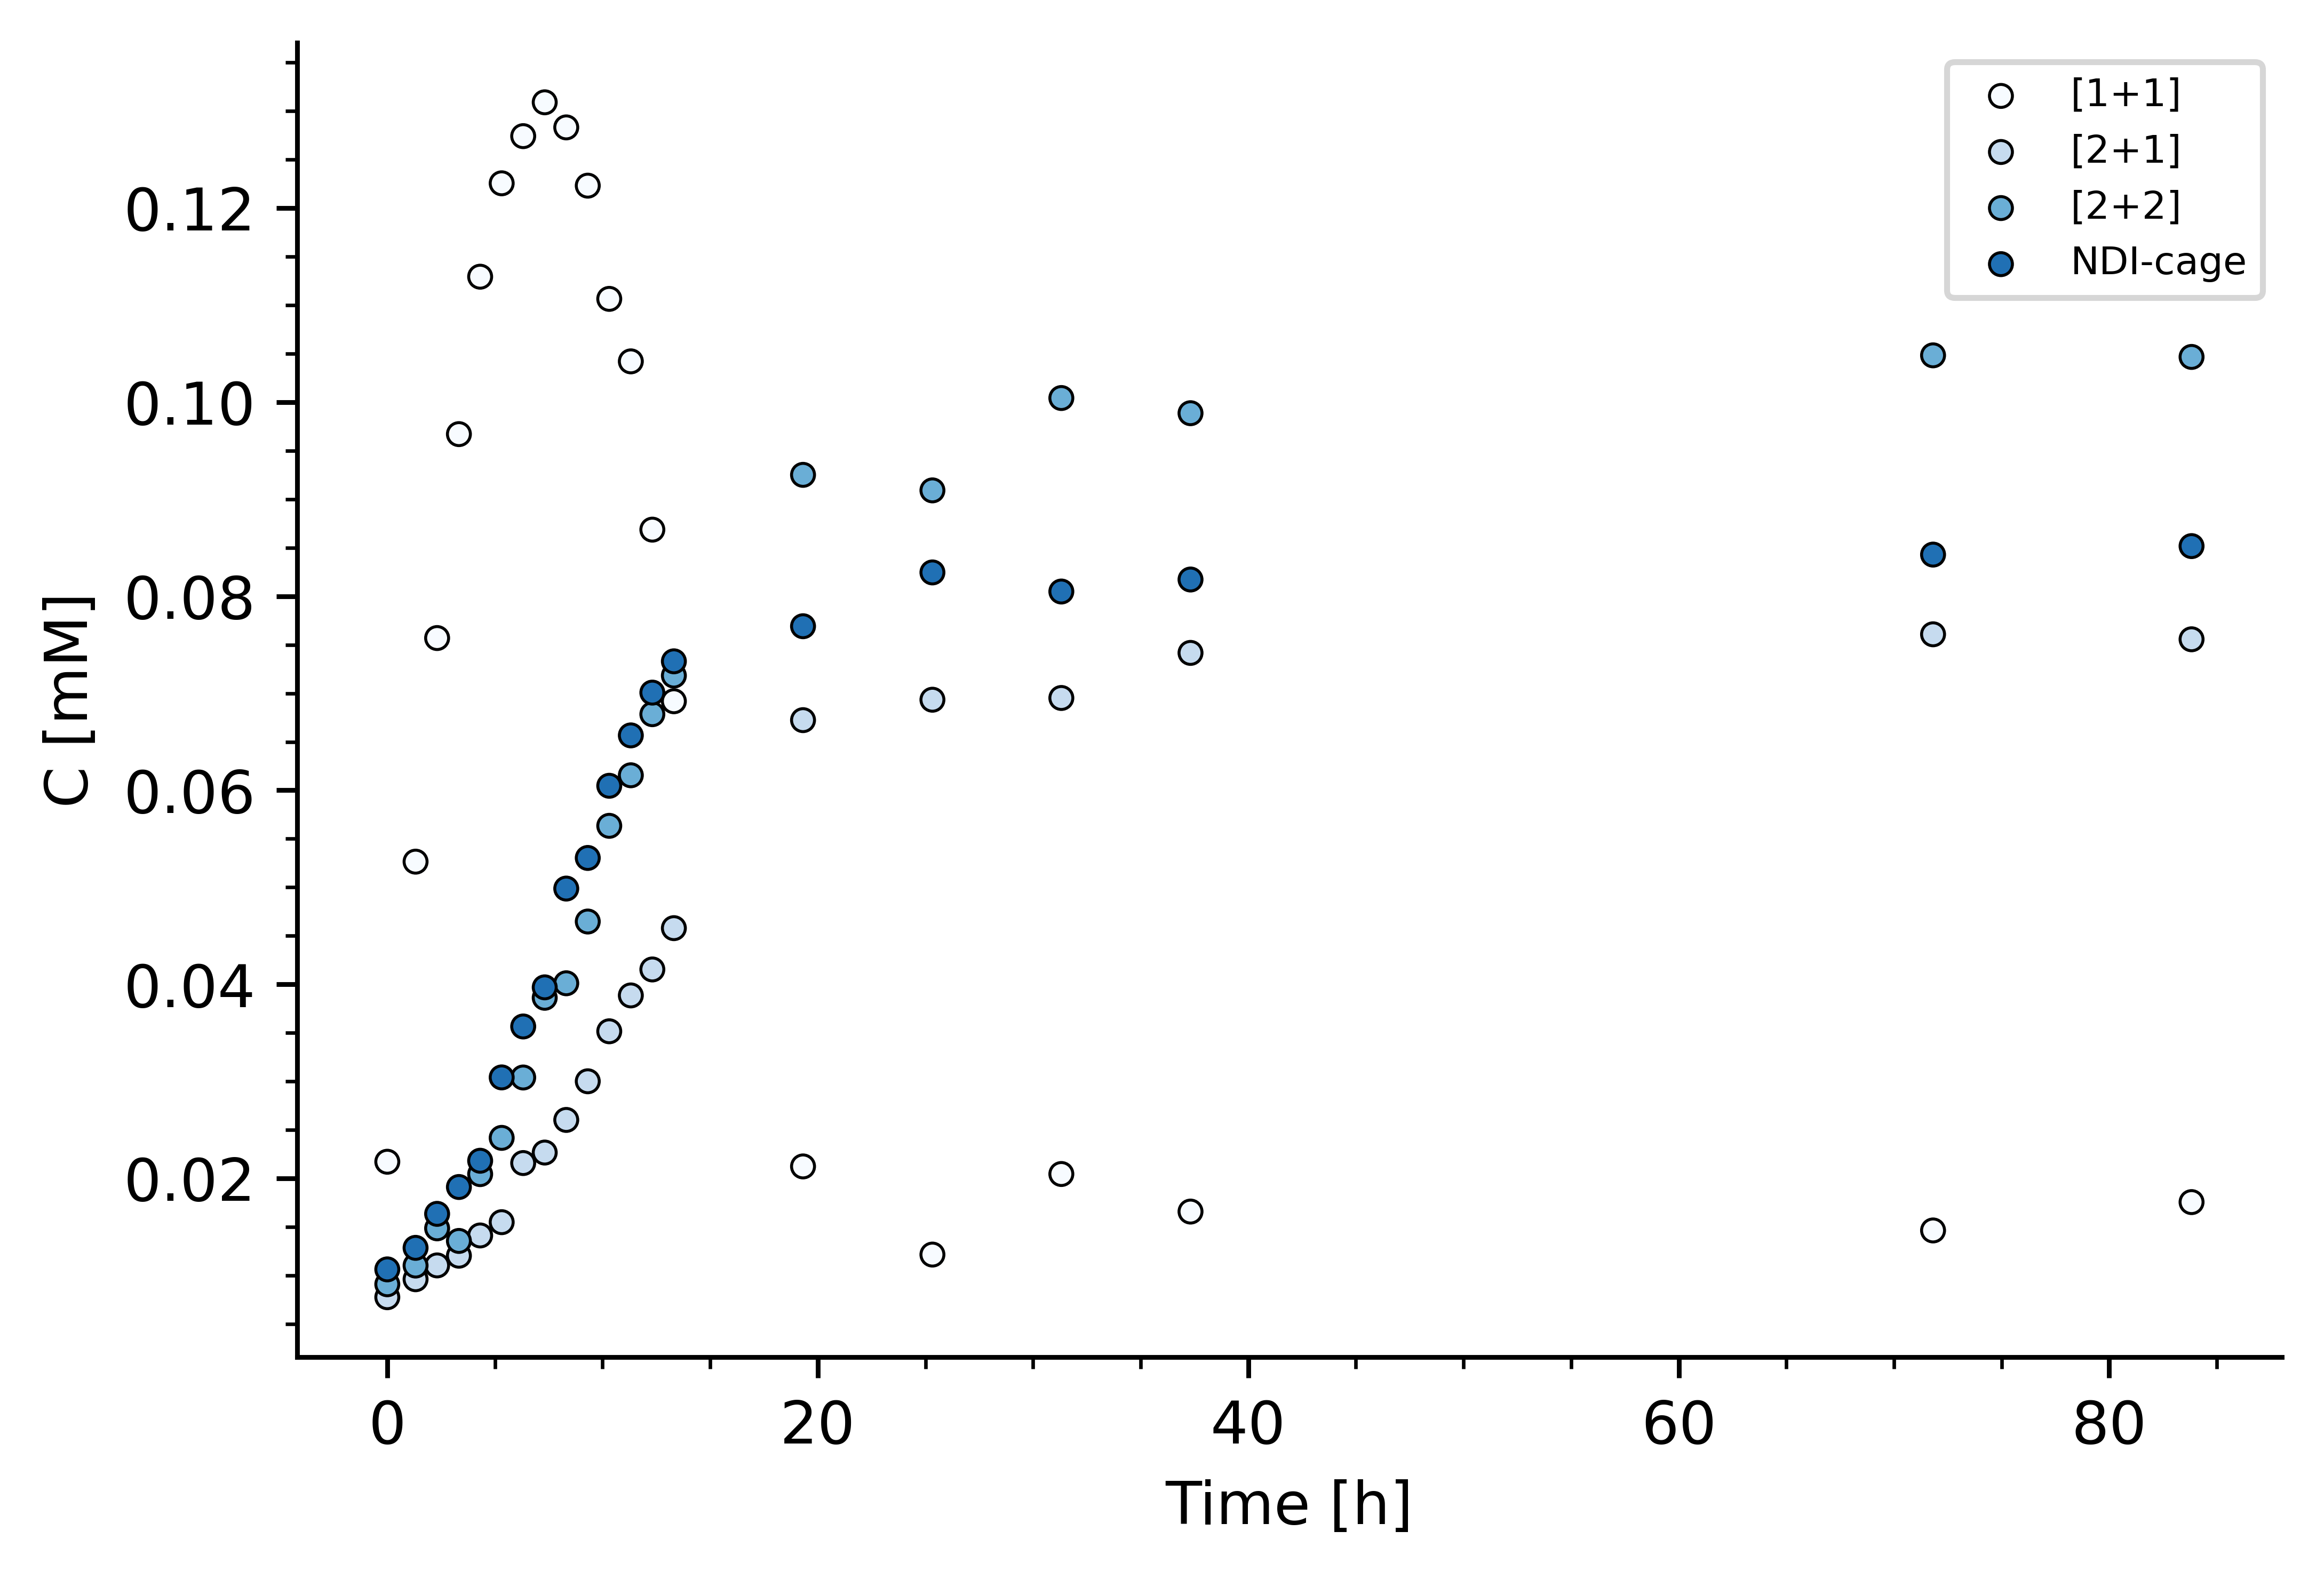

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from google.colab import drive

# Mount directory and the data file
drive.mount('/content/drive')

# Define the directory paths
input_directory = '/content/drive/MyDrive/ColabNotebooks/NMR/input_test/presentation/dry/P1'
output_directory = '/content/drive/MyDrive/ColabNotebooks/NMR/output_test/'

# Define your correction coefficient here
# Allows to correct for potential errors with the determined concentration.

coefficient = 1

def create_run_subfolder(output_directory, filename):
    """
    Creates a subfolder within the specified output directory. The subfolder's name is
    based on the current timestamp and a given filename.

    Parameters:
    output_directory (str): The path to the output directory.
    filename (str): The base filename to be included in the subfolder's name.

    Returns:
    str: The path to the newly created subfolder.
    """
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M")
    subfolder_name = f"{timestamp}_{filename}"
    run_output_directory = os.path.join(output_directory, subfolder_name)
    os.makedirs(run_output_directory, exist_ok=True)
    return run_output_directory

def load_data(input_directory, coefficient):
    """
    Loads and processes data from text files in the given input directory.
    Each file's data is scaled by the provided coefficient.

    Parameters:
    input_directory (str): Directory path where the text files are located.
    coefficient (float): A scaling coefficient to be applied to the data.

    Returns:
    tuple: A tuple containing a list of DataFrames (one for each text file),
           a list of headers from these DataFrames, and the name of the first text file.
    """
    # Initialize lists to store data and headers
    txt_data_list = []
    header_list = []
    first_txt_filename = None

    # List of encodings to try for reading the files
    encodings_to_try = ['utf-8', 'ISO-8859-1', 'Windows-1252', 'latin1', 'cp1252']

    # Iterate through the files in the input directory
    for file_name in os.listdir(input_directory):
        file_path = os.path.join(input_directory, file_name)

        # Process only .txt files
        if file_name.endswith('.txt'):
            if first_txt_filename is None:
                first_txt_filename = os.path.splitext(file_name)[0]

            # Try reading the file with different encodings
            for encoding in encodings_to_try:
                try:
                    with open(file_path, 'r', encoding=encoding) as txt_file:
                        df = pd.read_csv(txt_file, delimiter='\t')

                        # Multiply all columns except the first (time) by the coefficient
                        df.iloc[:, 1:] *= coefficient

                        txt_data_list.append(df)
                        header_list.append(list(df.columns))
                        break  # Break the loop if file is read successfully
                except (pd.errors.EmptyDataError, pd.errors.ParserError) as e:
                    print(f"Error parsing .txt file {file_name} with encoding {encoding}: {e}")
                except Exception as e:
                    print(f"Error reading .txt file {file_name}: {e}")

    # Return the loaded data and headers
    return txt_data_list, header_list, first_txt_filename

def average_data(txt_data_list):
    """
    Calculates the average and standard deviation across a list of DataFrames.
    This function is intended for use with time-series data where each DataFrame
    represents a separate dataset.

    Parameters:
    txt_data_list (list of pandas.DataFrame): List of DataFrames to average.

    Returns:
    tuple: A tuple containing two DataFrames, one for the mean values and
           another for the standard deviations.
    """
    if len(txt_data_list) < 1:
        print("There are not enough dataframes in the list.")
        return None, None

    max_rows = max(df.shape[0] for df in txt_data_list)
    max_cols = max(df.shape[1] for df in txt_data_list)
    mean_values = [[] for _ in range(max_cols)]
    std_values = [[] for _ in range(max_cols)]
    header = list(txt_data_list[0].columns)

    # Iterate over each column position
    for col_position in range(max_cols):
        column_values = []

        # Collect values for each dataframe, padding with NaN if necessary
        for df in txt_data_list:
            if col_position < len(df.columns):
                values = df.iloc[:, col_position].tolist()
                values.extend([np.nan] * (max_rows - len(values)))  # Pad with NaNs
                column_values.append(values)
            else:
                # If the dataframe does not have this column, append NaN values
                column_values.append([np.nan] * max_rows)

        # Vertically stack and calculate mean and std, handling NaN values
        col_stack = np.vstack(column_values)
        mean_values[col_position] = np.nanmean(col_stack, axis=0)
        std_values[col_position] = np.nanstd(col_stack, axis=0)

    # Construct mean and std DataFrames
    mean_df = pd.DataFrame(mean_values).T
    std_df = pd.DataFrame(std_values).T
    if len(header) < max_cols:
        header.extend([f'Unknown_{i}' for i in range(len(header), max_cols)])
    mean_df.columns = header
    std_df.columns = header

    return mean_df, std_df


# This function would allow to insert zoom insets for a region within specified x- and y-limits
"""def add_zoomed_inset(ax, time, mean_df, data_columns, segmented_colors, marker_type):
    axins = ax.inset_axes([0.35, 0.535, 0.45, 0.45])
    axins.set_xlim(-0.3, 14)
    axins.set_ylim(0, 0.4)
    axins.minorticks_on()
    axins.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axins.yaxis.set_minor_locator(plt.MultipleLocator(0.02))

    for idx, col in enumerate(data_columns):
        label = col
        axins.scatter(time, mean_df[col], label=label, c=[segmented_colors[idx]] * len(time), edgecolors='black', linewidth=0.5, marker=marker_type, s=25)

    ax.indicate_inset_zoom(axins)"""

def poly_func_degree(x, *coefficients):
    """
    Represents a polynomial function of a given degree.

    Parameters:
    x (array-like): The independent variable.
    *coefficients (list): Coefficients of the polynomial, starting from the highest degree.

    Returns:
    numpy.ndarray: The calculated polynomial values.
    """
    degree = len(coefficients) - 1
    return sum(c * x**(degree - i) for i, c in enumerate(coefficients))

def fit_all_columns_with_best_function(mean_df, potential_functions):
    """
    Fits each column in a DataFrame with a set of potential functions and identifies
    the best fitting function based on R² score.

    Parameters:
    mean_df (pandas.DataFrame): DataFrame containing the data to be fitted.
    potential_functions (list of callable): List of functions to use for fitting.

    Returns:
    dict: A dictionary with column names as keys and details of the best fit
          (function, parameters, R² score) as values.
    """
    fitting_results = {}

    for col in mean_df.columns[1:-1]:
        best_function = None
        best_r2 = -1

        for func in potential_functions:
            try:
                if func == poly_func_degree:
                    # Provide initial guess for poly_func_degree
                    popt, pcov = curve_fit(func, mean_df['time'], mean_df[col], p0=[0.0] * 10, maxfev=3000)
                else:
                    popt, pcov = curve_fit(func, mean_df['time'], mean_df[col])
                y_fit = func(mean_df['time'], *popt)
                r2 = r2_score(mean_df[col], y_fit)

                if r2 > best_r2:
                    best_r2 = r2
                    best_function = func
                    best_popt = popt
                    best_pcov = pcov
            except Exception as e:
                print(f"Error fitting and optimizing for column {col} with function {func.__name__}: {e}")

        fitting_results[col] = {'best_function': best_function, 'best_popt': best_popt, 'best_pcov': best_pcov, 'best_r2': best_r2}

    return fitting_results

def plot_and_fit_data_with_best_function(mean_df, std_df, output_directory, input_filename):
    """
    Plots the data along with error bars and fits each column with the best function.
    Outputs the plot in various formats and saves the fitting results.

    Parameters:
    mean_df (pandas.DataFrame): DataFrame containing mean values.
    std_df (pandas.DataFrame): DataFrame containing standard deviations.
    output_directory (str): Directory path for saving output files.
    input_filename (str): The base filename to be used for saving output files.

    Returns:
    None
    """
    # Define the colormap giving
    colormaps = ['Blues']
    marker_types = ['o']
    time = mean_df['time']
    data_columns = mean_df.columns[1:-1]

    fig, ax = plt.subplots(figsize=(6, 4), dpi=800)

    potential_functions = [poly_func_degree]
    fitting_results = fit_all_columns_with_best_function(mean_df, potential_functions)

    for idx, col in enumerate(data_columns):
        colormap = plt.colormaps[colormaps[idx % len(colormaps)]]  # Updated line
        marker_type = marker_types[idx % len(marker_types)]
        segmented_colors = [colormap(i / len(data_columns)) for i in range(len(data_columns))]
        label = col

        # Retrieve fitting results for the current column
        fitting_result = fitting_results.get(col, {})
        best_function = fitting_result.get('best_function', None)
        best_popt = fitting_result.get('best_popt', None)

#        if best_function is not None and best_popt is not None:
            # Plot the regression line first (background)
#            ax.plot(time, best_function(time, *best_popt), label=f"{col} (Fit)", linestyle='-', color=segmented_colors[idx], zorder=1)

        # Plot the error bars next (middle)
        ax.errorbar(time, mean_df[col], yerr=std_df[col], fmt='none', ecolor='black', elinewidth=0.5, capsize=2, capthick=0.5, zorder=2)

        # Finally plot the data points (front)
        ax.scatter(time, mean_df[col], label=label, c=[segmented_colors[idx]] * len(time), edgecolors='black', linewidth=0.5, marker=marker_type, s=15, zorder=3)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Time [h]")
    ax.set_ylabel('C [mM]')
    ax.minorticks_on()
    ax.legend(loc='best', prop={'size': 6.5})

    run_output_directory = create_run_subfolder(output_directory, f'plots_{input_filename}')

    # Save the fitting results, mean_df DataFrame, and figure
    results_txt_filepath = os.path.join(run_output_directory, f'fitting_results_{input_filename}.txt')
    with open(results_txt_filepath, 'w') as results_file:
        results_file.write("Column\tBest Function\tOptimized Parameters\tR²\n")
        for col, fitting_result in fitting_results.items():
            best_function_name = fitting_result.get('best_function', lambda x: "None").__name__
            best_popt = fitting_result.get('best_popt', "None")
            best_r2 = fitting_result.get('best_r2', "None")
            results_file.write(f"{col}\t{best_function_name}\t{best_popt}\t{best_r2}\n")

    mean_df_filepath = os.path.join(run_output_directory, f'mean_df_{input_filename}.csv')
    mean_df.to_csv(mean_df_filepath, index=False)

    png_filepath = os.path.join(run_output_directory, f'figure_{input_filename}.png')
    plt.savefig(png_filepath, dpi=800, bbox_inches='tight')

    pdf_filepath = os.path.join(run_output_directory, f'figure_{input_filename}.pdf')
    plt.savefig(pdf_filepath, format='pdf', bbox_inches='tight')

    svg_filepath = os.path.join(run_output_directory, f'figure_{input_filename}.svg')
    plt.savefig(svg_filepath, format='svg', bbox_inches='tight')

    plt.show()

# Main script execution, data is loaded from a specified input directory and scaled by the coefficient
txt_data_list, header_list, first_txt_filename = load_data(input_directory, coefficient)

# Define run_output_directory here, create subfolder based on the filename
run_output_directory = create_run_subfolder(output_directory, first_txt_filename)

# Print the headers of each loaded text DataFrame for verification
for i, header in enumerate(header_list):
    print(f"Text DataFrame {i} Header:\n{header}")

# Calculate the average and standard deviation of the loaded data
mean_df, std_df = average_data(txt_data_list)

# Save mean_df and std_df using the defined run_output_directory
mean_df_filepath = os.path.join(run_output_directory, f'mean_df_{first_txt_filename}.csv')
mean_df.to_csv(mean_df_filepath, index=False)

std_df_filepath = os.path.join(run_output_directory, f'std_df_{first_txt_filename}.csv')
std_df.to_csv(std_df_filepath, index=False)

# Display the mean DataFrame
print(mean_df)

# Pass run_output_directory to the function
plot_and_fit_data_with_best_function(mean_df, std_df, run_output_directory, first_txt_filename)
